# 2CS SIL2-SIQ2 Lab02. Decision trees and Ensemble learning

<p style='text-align: right;font-style: italic;'>Designed by: Dr. Abdelkrime Aries</p>

In this lab, we will learn all about decision trees and ensemble learning.


**Team:**
- **Member 01**: HEDDADJI Nour el Imane
- **Member 02**: SOLTANI Meriem
- **Group**: SIQ2

In [ ]:
import sys, timeit
from typing          import Tuple, List, Type, Union
from collections.abc import Callable

sys.version

'3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]'

In [ ]:
import numpy            as np
import pandas            as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

np.__version__, pd.__version__, matplotlib.__version__

('1.25.2', '2.0.3', '3.7.1')

In [ ]:
import sklearn

from sklearn.model_selection import train_test_split
# from sklearn.preprocessing   import StandardScaler
from sklearn.linear_model    import LogisticRegression
from sklearn.linear_model    import SGDClassifier
# from sklearn.multiclass      import OneVsRestClassifier
# from sklearn.multiclass      import OneVsOneClassifier
from sklearn.metrics         import accuracy_score
# from sklearn.metrics         import classification_report
# from sklearn.metrics         import log_loss

from   sklearn.tree    import DecisionTreeClassifier
from   sklearn.metrics import f1_score
from   sklearn         import tree
from   sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble     import BaggingClassifier
from sklearn.ensemble     import AdaBoostClassifier
from sklearn.ensemble     import StackingClassifier


sklearn.__version__

'1.2.2'

In [ ]:
# This code is used to filter warnings concerning convergence
# In general, when the maximum number of iterations is not suffisant to converge
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)

## I. Algorithms implementation

In this section, we will try to implement ID3 and CART decision trees.

### I.1. ID3

Here, we will try to implement ID3 algorithm for categorical features.

In [ ]:
# Dataset play

# outlook & temperature & humidity & windy
Xplay = np.array([
    ['sunny'   , 'hot' , 'high'  , 'no'],
    ['sunny'   , 'hot' , 'high'  , 'yes'],
    ['overcast', 'hot' , 'high'  , 'no'],
    ['rainy'   , 'mild', 'high'  , 'no'],
    ['rainy'   , 'cool', 'normal', 'no'],
    ['rainy'   , 'cool', 'normal', 'yes'],
    ['overcast', 'cool', 'normal', 'yes'],
    ['sunny'   , 'mild', 'high'  , 'no'],
    ['sunny'   , 'cool', 'normal', 'no'],
    ['rainy'   , 'mild', 'normal', 'no'],
    ['sunny'   , 'mild', 'normal', 'yes'],
    ['overcast', 'mild', 'high'  , 'yes'],
    ['overcast', 'hot' , 'normal', 'no'],
    ['rainy'   , 'mild', 'high'  , 'yes']
])

Yplay = np.array([
    'no',
    'no',
    'yes',
    'yes',
    'yes',
    'no',
    'yes',
    'no',
    'yes',
    'yes',
    'yes',
    'yes',
    'yes',
    'no'
])

len(Xplay), len(Yplay)

(14, 14)

#### I.1.1. Probability

Given:
- $v$: a given value
- $S$: a set

the probability of this value given the set is its frequency in the set divided by the set's size

$$p(v/S) = \frac{|\{x / x \in S \text{ et } x = v\}|}{|S|}$$


**>> P.S. If the division always returns 0, try applying float(x) on integer numbers**

In [ ]:
# TODO: Probability of a value given a set
def Pfn(v: str, S: np.ndarray) -> float:
    return np.count_nonzero(S == v)/S.size

#=====================================================================
# UNIT TEST
#=====================================================================
# Result:
# (0.6428571428571429,
#  0.35714285714285715,
#  0.2857142857142857,
#  0.35714285714285715)
#---------------------------------------------------------------------

Pfn('yes'     , Yplay      ), \
Pfn('sunny'   , Xplay[:, 0]), \
Pfn('overcast', Xplay[:, 0]), \
Pfn('rainy'   , Xplay[:, 0])

(0.6428571428571429,
 0.35714285714285715,
 0.2857142857142857,
 0.35714285714285715)

#### I.1.2. Uncertainty of a set

Given:
- $S$: a set
- $V$: a set of unique values of $S$ (vocabulary)

Shannon's entropy is calculated as:
$$H(S) = - \sum\limits_{v \in V} p(v/S) \log_2 p(v/S)$$


**>> P.S. np.log2 calculate log2 of a scalar, vector or matrix**

In [ ]:
# TODO: Entropy
def Hfn(S: np.ndarray) -> float:
    V = np.unique(S)
    entropy = 0
    for v in V :
        proba = Pfn(v,S)
        entropy += -1 *proba*np.log2(proba)
    # Complete here
    return entropy

#=====================================================================
# UNIT TEST
#=====================================================================
# Result:
# (0.9402859586706311, 1.5774062828523454)
#---------------------------------------------------------------------

Hfn(Yplay), Hfn(Xplay[:,0])

(0.9402859586706311, 1.5774062828523454)

#### I.1.3. Set splitting

**>> Nothing to code here**

Given:
- $Y$: a list to split.
- $A$: a list of an attribut's values (feature, column).
- $v$: the value of $A$ on which $Y$ will be split.

The split is:
$$S_{A,v} = \{y^{(i)} \in Y / a^{(i)} \in A \wedge a^{(i)} = v\}\}$$


In [ ]:
def split_ID3(Y: np.ndarray, A: np.ndarray, v: str) -> np.ndarray:
    msk = A == v
    return Y[msk]

#=====================================================================
# UNIT TEST
#=====================================================================
# Result:
# array(['no', 'no', 'no', 'yes', 'yes'], dtype='<U3')
#---------------------------------------------------------------------

split_ID3(Yplay, Xplay[:,0], 'sunny')

array(['no', 'no', 'no', 'yes', 'yes'], dtype='<U3')

#### I.1.4. Information gain

Given:
- $Y$: a list to split.
- $A$: a list of an attribut's values (feature, column).
- $V$: a list of unique values of $A$ (vocabulary).
- $(v/A)$: the probability of occurence of $v$ in $A$
- $Y_{A, v}$: subset of $Y$ where the values of $A$ equal $v$ (using the past implemented function split_ID3)

Informtion gain is calculated as:

$$IG(Y, A) = H(Y) - \sum_{v \in V} p(v/A) H(Y_{A, v})$$

**>> The function must return a tuple (Information gain, entropy)**

In [ ]:
# TODO: Information gain
def IGfn(Y: np.ndarray, A: np.ndarray) -> Tuple[float, float]:
    V = np.unique(A)
    entropy = Hfn(Y)
    res = 0
    for v in V :
        res +=  Hfn(split_ID3(Y,A,v))* Pfn(v,A)
    ig = entropy - res
    # Complete here

    return ig, entropy


#=====================================================================
# UNIT TEST
#=====================================================================
# Result:
# (0.24674981977443933, 0.9402859586706311)
#---------------------------------------------------------------------

IGfn(Yplay, Xplay[:, 0])

(0.24674981977443933, 0.9402859586706311)

#### I.1.5. ID3 splitting feature selection

Given:
- $X[M, N]$: a matrix of $M$ samples and $N$ categorical features
- $Y[M]$: a vector of output labels

We want to find the feature which maximizes:

$$best_j = \arg\max_j IG(Y, X_j)$$

- **>> The function must return a tuple (nfeature order, IG, entropy)**

In [ ]:
# TODO: ID3 splitting feature selection
def choose_split_ID3(X: np.ndarray, Y: np.ndarray) -> Tuple[int, float, float]:
    bestj    = -1   # number of the best feature
    ig_bestj = -1.0 # IG of the best feature
    h_bestj  = -1.0 # Entropy of the best feature
    # Complete here
    for f in range(X.shape[1]):
        v = X[:, f]
        ig, entropy = IGfn(Y, v)
        if ig > ig_bestj:
            bestj = f
            ig_bestj = ig
            h_bestj = entropy


    return bestj, ig_bestj, h_bestj

#=====================================================================
# UNIT TEST
#=====================================================================
# Result:
# (0, 0.24674981977443933, 0.9402859586706311)
#---------------------------------------------------------------------

choose_split_ID3(Xplay, Yplay)

(0, 0.24674981977443933, 0.9402859586706311)

#### I.1.6. Stopping Criterion

Given:
- $Y$: a set of outupt labels in a given node
- $h$: the homogeneity criterion. h = 0 ==> the set Y is homogeneous (same values)
- $nbr_min$: the minimum number of samples in a node. |Y| <= nbr_min ==> the node must be a leaf

the function must return:
- The name of the class: if the set is homogeneous or it contains a minimum number of elements
- None: otherwise

**>> HINT: use numpy.unique and numpy.argmax**

In [ ]:
# TODO: ID3 Stopping Criterion
def stop_ID3(Y: np.ndarray, h: float, nbr_min: int) -> Union[str, None]:
    if h == 0:
        # h = 0 ==> the set Y is homogeneous (same values)
        unique_v, counts = np.unique(Y, return_counts=True)
        freq_ind = np.argmax(counts)
        return unique_v[freq_ind]
    if len(Y) <= nbr_min:
        unique_v, counts = np.unique(Y, return_counts=True)
        freq_ind= np.argmax(counts)
        # Return the most frequent class
        return unique_v[freq_ind]
#=====================================================================
# UNIT TEST
#=====================================================================
# Result:
# ('yes', 'no', None)
#---------------------------------------------------------------------

Y_t1 = np.array(['yes', 'yes', 'yes'])
Y_t2 = np.array(['yes', 'no', 'no'])

stop_ID3(Y_t1, Hfn(Y_t1), 2), \
stop_ID3(Y_t2, Hfn(Y_t2), 4), \
stop_ID3(Y_t2, Hfn(Y_t2), 2)

('yes', 'no', None)

#### I.1.7. Tree construction

**>> Nothing to code here**


In [ ]:
# A class to represent a node
class Node(object):

    nbr = 0

    def __init__(self, f:int, ig:float, h:float, depth:int):
        self.f        = f        # le numéro du caractéristique de dévision dans X
        self.ig       = ig         # le IG de division
        self.h        = h          # l'entropie H
        self.depth    = depth      # la profondeur du noeud
        self.children = {}         # les fils ; un dictionnaire valeur : noeud
        self.cls      = ''         # la classe si ce noeud est final (s'il n'y a pas de fils)
        self.indent   = '    '     # indentation lorsqu'on génère le code

    # Cette fonction est pour transformer le noeud à une string
    #Ici, nous avons redéfini cette fonction afin qu'elle écrive l'arbre
    #sous form d'un algorithme ; c'est un parser
    def __str__(self):

        indent = self.indent * self.depth # indentation : esthetique

        # s'il n'y a pas de fils, le noeud est terminal ; on imprime la classe
        if (len(self.children)==0):
            return indent + 'Y IS "' + self.cls + '"\n'

        # s'il y a des fils, on boucle sur les fils et on imprime des SI ... ALORS
        res = ""
        for f_v in self.children:
            res += indent + 'IF X[' + str(self.f) + '] IS "' + str(f_v)
            res += '" THEN\n' + str(self.children[f_v])
        return res

    # predirct a sample
    def predict(self, x: List[str]) -> str:

        # If the node is final, return its class
        if (len(self.children)==0):
            return self.cls

        # If the value of this node's feature is not in its children
        # return np.nan
        if x[self.f] not in self.children:
            return np.nan

        # Otherwise, it returns the prediction of the child
        return self.children[x[self.f]].predict(x)

    def graphviz(self):

        nid = 'N' + str(Node.nbr)
        Node.nbr += 1

        if (len(self.children)==0):
            return nid, nid + '[label="' + self.cls + '" shape=ellipse];\n'

        res  = nid + '[label="X[' + str(self.f) + ']\\n'
        # res += 'H = ' + str(self.h) + '\\n'
        # res += 'IG = ' + str(self.ig) + '"];\n'
        res += 'H = {:.5f}\\n'.format(self.h)
        res += 'IG = {:.5f}"];\n'.format(self.ig)
        for f in self.children:
            vid, code = self.children[f].graphviz()
            res += code
            res += nid + ' -> ' + vid + ' [label="' + f + '"];\n'
        return nid, res


def fit_ID3(X:np.ndarray, Y:np.ndarray, nbr_min:int=0, depth:int=0):

    bestj, ig_bestj, h_bestj = choose_split_ID3(X, Y)
    noeud = Node(bestj, ig_bestj, h_bestj, depth)
    cls = stop_ID3(Y, h_bestj, nbr_min)
    if cls:
        noeud.cls = cls
        return noeud

    depth += 1
    for v in np.unique(X[:, bestj]):
        msk = X[:, bestj] == v
        X_v = X[msk]
        Y_v = Y[msk]
        child = fit_ID3(X_v, Y_v, nbr_min=nbr_min, depth=depth)
        noeud.children[v] = child

    return noeud

#=====================================================================
# UNIT TEST
#=====================================================================
# Result:
# The code
# IF X[0] IS "overcast" THEN
#     Y IS "yes"
# IF X[0] IS "rainy" THEN
#     IF X[3] IS "no" THEN
#         Y IS "yes"
#     IF X[3] IS "yes" THEN
#         Y IS "no"
# IF X[0] IS "sunny" THEN
#     IF X[2] IS "high" THEN
#         Y IS "no"
#     IF X[2] IS "normal" THEN
#         Y IS "yes"
#
# 'yes'
#---------------------------------------------------------------------

DTplay = fit_ID3(Xplay, Yplay)

print('The code')
print(DTplay)

# Test a sample
DTplay.predict(['rainy', 'temperature_makanche', 'humidity_makanche', 'no'])

The code
IF X[0] IS "overcast" THEN
    Y IS "yes"
IF X[0] IS "rainy" THEN
    IF X[3] IS "no" THEN
        Y IS "yes"
    IF X[3] IS "yes" THEN
        Y IS "no"
IF X[0] IS "sunny" THEN
    IF X[2] IS "high" THEN
        Y IS "no"
    IF X[2] IS "normal" THEN
        Y IS "yes"



'yes'

#### I.1.8. Final product

**>> Nothing to code here**

In [ ]:
class ID3(object):

    def fit(self, X, Y, features=[], clsname='', nbr_min=0):
        self.tree = fit_ID3(X, Y, nbr_min=nbr_min)
        code = str(self.tree)
        if len(clsname) > 0:
            code = code.replace('Y', clsname)
        for i in range(len(features)):
            code = code.replace('X[' + str(i) + ']', features[i])
        self.code = code
        self.features = features

    def predict(self, X):
        predictions = []
        for i in range(len(X)):
            predictions.append(self.tree.predict(X[i, :]))
        return predictions

    def graphviz(self):
        nid, code = self.tree.graphviz()
        res  = 'digraph Tree {\n'
        res += 'node [shape=box] ;'
        for i in range(len(self.features)):
            code = code.replace('X[' + str(i) + ']', self.features[i])
        res += code
        res += '}'
        return res

#=====================================================================
# UNIT TEST
#=====================================================================
# Result:
# IF outlook IS "overcast" THEN
#     play IS "yes"
# IF outlook IS "rainy" THEN
#     IF windy IS "no" THEN
#         play IS "yes"
#     IF windy IS "yes" THEN
#         play IS "no"
# IF outlook IS "sunny" THEN
#     IF humidity IS "high" THEN
#         play IS "no"
#     IF humidity IS "normal" THEN
#         play IS "yes"
#---------------------------------------------------------------------

features=['outlook', 'temperature', 'humidity', 'windy']

id3_classifier = ID3()
id3_classifier.fit(Xplay, Yplay, features=features, clsname='play')
print(id3_classifier.code)

IF outlook IS "overcast" THEN
    play IS "yes"
IF outlook IS "rainy" THEN
    IF windy IS "no" THEN
        play IS "yes"
    IF windy IS "yes" THEN
        play IS "no"
IF outlook IS "sunny" THEN
    IF humidity IS "high" THEN
        play IS "no"
    IF humidity IS "normal" THEN
        play IS "yes"



In [ ]:
# !pip install graphviz
# Also you need to install the graphviz backend in the system
# Lien : https://graphviz.org/download/

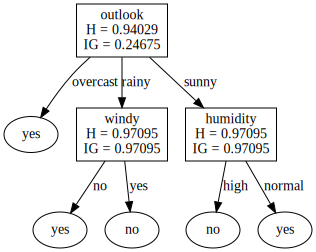

In [ ]:
# It's just a visualization of the graph
# If it doesn't work, it doesn't matter
try:
    from IPython.display import SVG
    from graphviz        import Source
    from IPython.display import display

    graph = Source(id3_classifier.graphviz())
    display(SVG(graph.pipe(format='svg')))

except ImportError:
    print('You have to install graphviz: https://graphviz.org/download/')

### I.2. CART

Here, we will try to implement CART algorithm for numerical features.


In [ ]:
# temperature & humidity & windy
Xnplay = np.array([
    [30, 85, 0],
    [27, 90, 1],
    [28, 78, 0],
    [21, 96, 0],
    [20, 80, 0],
    [18, 70, 1],
    [18, 65, 1],
    [22, 95, 0],
    [21, 70, 0],
    [24, 80, 0],
    [24, 70, 1],
    [22, 90, 1],
    [27, 75, 0],
    [22, 80, 1]
])

Ynplay = Yplay

len(Xnplay), len(Ynplay)

(14, 14)

#### I.2.1. Gini diversity index (Gini impurity)

Given:
- $S$: a set
- $V$: a set of unique values of $S$ (vocabulary)

Gini is calculated by:
$$Gini(S) = \sum\limits_{v \in V} p(v/S) (1-p(v/S)) = 1 - \sum\limits_{v \in V} p(v/S)^2 $$

In [ ]:
# TODO: Gini impurity
def Gini(S: np.ndarray) -> float:
    V = np.unique(S)
    gini = 1
    # Complete here
    for v in V :
        gini = gini - (Pfn(v,S))**2
    return gini

#=====================================================================
# UNIT TEST
#=====================================================================
# Result:
# 0.4591836734693877
#---------------------------------------------------------------------

Gini(Ynplay)

0.4591836734693877

#### I.2.2. Set splitting

**>> Nothing to code here**

Given:
- $Y$: a list to split.
- $A$: a list of an attribut's values (feature, column).
- $v$: the value of $A$ on which $Y$ will be split.


The list is split into two subsets:
- $Y_L$: a subset of $Y$ where $A > v$
- $Y_R$: a subset of $Y$ where $A \le v$


In [ ]:
def split_CART(Y:np.ndarray, A:np.ndarray, v:float):
    msk = A > v
    return Y[msk], Y[~msk]

#=====================================================================
# UNIT TEST
#=====================================================================
# Result:
# (array(['no', 'no', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'yes',
#         'no'], dtype='<U3'),
#  array(['yes', 'no', 'yes'], dtype='<U3'))
#---------------------------------------------------------------------

split_CART(Ynplay, Xnplay[:,0], 20)

(array(['no', 'no', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'yes',
        'no'], dtype='<U3'),
 array(['yes', 'no', 'yes'], dtype='<U3'))

#### I.2.3. Gini impurity for the split

Given:
- $Y$: a list to split.
- $S_L, G_R$: subsets left and right
- $|S| = |S_L| + |S_R|$

Gini impurity for the split is calculated as:

$$Gini_{split}(S_L, S_R) = \frac{|S_L|}{|S|} Gini(S_L) + \frac{|S_R|}{|S|} Gini(S_R)$$


In [ ]:
# TODO: Gini impurity for the split
def Gini_split(S_L: np.ndarray, S_R: np.ndarray) -> float:
    S_len = float(len(S_L) + len(S_R))
    # Complete here

    return (float(len(S_L))/S_len) * Gini(S_L) + (float(len(S_R))/S_len) * Gini(S_R)

#=====================================================================
# UNIT TEST
#=====================================================================
# Result:
# 0.4588744588744589
#---------------------------------------------------------------------

S_L, S_R = split_CART(Ynplay, Xnplay[:, 0], 20)
Gini_split(S_L, S_R)

0.4588744588744589

#### I.2.4. CART splitting feature and value selection

Algorithm:
- For each feature $X_j$
   - For each value $v \in unique(X_j)$
       1. Split $Y$ given $X_j$ and $v$
       1. Calculate Gini diversity of the division
       1. Save **bestj** the order of the feature which minimizes Gini impurity for the split
       1. Save Gini diversity of the division minimal **gini_bestj**
       1. Save the value of split **v_jbest**
       

In [ ]:
# TODO: Choice of CART splitting feature and value
def choose_split_CART(X: np.ndarray, Y: np.ndarray) -> Tuple[int, float, float]:
    bestj      = -1
    gini_bestj =  1.0
    v_bestj    = -1.0
    # Complete here
    j = -1
    for Xj in X.T:
        list_Gini = []
        j += 1
        for v in np.unique(Xj):
            S_L, S_R = split_CART(Y, Xj, v)
            list_Gini.append(Gini_split(S_L, S_R))
        if list_Gini:
            gini = list_Gini[np.argmin(list_Gini)]
            if gini < gini_bestj:
                gini_bestj = gini
                bestj = j
                v_bestj = Xj[list_Gini.index(gini)]
    return bestj, gini_bestj, v_bestj

#=====================================================================
# UNIT TEST
#=====================================================================
# Result:
# (1, 0.3936507936507937, 80)
#---------------------------------------------------------------------

choose_split_CART(Xnplay, Ynplay)

(1, 0.3936507936507937, 80)

#### I.2.5. Stopping Criterion

**>> Nothing to code here**

The same as stop_ID3. Gini is passed in arguments instead of Entropy.

In [ ]:
stop_CART = stop_ID3

#=====================================================================
# UNIT TEST
#=====================================================================
# Result:
# ('yes', 'no', None)
#---------------------------------------------------------------------

Y_t1 = np.array(['yes', 'yes', 'yes'])
Y_t2 = np.array(['yes', 'no', 'no'])

stop_CART(Y_t1, Hfn(Y_t1), 2), \
stop_CART(Y_t2, Hfn(Y_t2), 4), \
stop_CART(Y_t2, Hfn(Y_t2), 2)

('yes', 'no', None)

#### I.2.6. Tree construction

**>> Nothing to code here**

In [ ]:
# Comme Noeud, mais il faut changer un peu, puisqu'on teste sur des
# valeurs numériques aussi
# Le code sera plus utilisable si on crée une classe commune et on hérite
# Mais, je n'ai pas le temps pour tout ça (DEAL WITH IT)
class NoeudBin(object):

    nbr = 0

    def __init__(self, f:int, val:int, gini:float, depth:int):
        self.f      = f        # le numéro du caractéristique de dévision dans X
        self.val    = val        # la valeur du noeud
        self.gini   = gini       # le Gini de division
        self.depth     = depth # la profondeur du noeud
        self.children = []         # les fils ; un tableau de deux noeuds: S_G, S_D
        self.cls    = ''         # la classe si ce noeud est final (s'il n'y a pas de fils)
        self.indent = '    '     # indentation lorsqu'on génère le code

    # Cette fonction est pour transformer le noeud à une string
    #Ici, nous avons redéfini cette fonction afin qu'elle écrive l'arbre
    #sous form d'un algorithme ; c'est un parser
    def __str__(self):

        indent = self.indent * self.depth # indentation : esthetique

        # s'il n'y a pas de fils, le noeud est terminal ; on imprime la classe
        if (len(self.children)==0):
            return indent + 'Y IS "' + self.cls + '"\n'

        prefix = ' > '
        suffix = ''

        # s'il y a des fils, on boucle sur les fils et on imprime des SI ... ALORS SINON
        res  = ''
        res += indent + 'IF X[' + str(self.f) + '] ' + prefix + str(self.val) + suffix
        res += ' THEN\n' + str(self.children[0])
        res += indent + 'ELSE\n' + str(self.children[1])
        return res

    # predire un échantillon
    def predict(self, x: List[float]):

        # If the node is a leaf
        if (len(self.children)==0):
            return self.cls

        # Otherwise
        if x[self.f] > self.val:
            return self.children[0].predict(x)
        return self.children[1].predict(x)


    # Generate graphviz code
    def graphviz(self):

        nid = 'N' + str(NoeudBin.nbr)
        NoeudBin.nbr += 1

        # If the node is a leaf
        if (len(self.children)==0):
            return nid, nid + '[label="' + self.cls + '" shape=ellipse];\n'

        # Otherwise,
        # loop over children and print IF ... ELSE
        prefix = '] > '
        res = nid + '[label="X[' + str(self.f) + prefix + str(self.val) + '\\n'
        res += 'Gini = {:.5f}"];\n'.format(self.gini)
        vid_L, code_L = self.children[0].graphviz()
        vid_R, code_R = self.children[1].graphviz()

        res += code_L + code_R
        res += nid + ' -> ' + vid_L + ' [label="TRUE"];\n'
        res += nid + ' -> ' + vid_R + ' [label="FALSE"];\n'
        return nid, res

def fit_CART(X: np.ndarray, Y: np.ndarray, depth: int = 0, nbr_min: int = 0) -> NoeudBin:
    # Get the best split feature, threshold, and Gini value
    bestj, gini_bestj, v_bestj = choose_split_CART(X, Y)

    # Create a new node
    noeud = NoeudBin(bestj, v_bestj, gini_bestj, depth)

    # Check stopping criterion
    cls = stop_CART(Y, gini_bestj, nbr_min)
    if cls:
        noeud.cls = cls  # Assign the class to the node
        return noeud

    # Increment depth for child nodes
    depth += 1

    # Create masks for the left and right child nodes
    msk = X[:, bestj] > v_bestj

    # Split the data
    X_L = X[msk]
    Y_L = Y[msk]
    X_R = X[~msk]
    Y_R = Y[~msk]

    # Ensure neither of the child subsets is empty before calling fit_CART
    if len(X_L) == 0 or len(X_R) == 0:
        # Encode Y and get the most frequent class
        encoder = LabelEncoder()
        Y_encoded = encoder.fit_transform(Y)
        most_frequent_class = np.unique(Y)[np.argmax(np.bincount(Y_encoded))]
        noeud.cls = most_frequent_class
        return noeud

    # Fit child nodes
    child_L = fit_CART(X_L, Y_L, depth, nbr_min)
    child_R = fit_CART(X_R, Y_R, depth, nbr_min)

    # Add children to the node
    noeud.children.append(child_L)
    noeud.children.append(child_R)

    return noeud

#=====================================================================
# UNIT TEST
#=====================================================================
# Result:
# The Code
# IF X[1]  > 80 THEN
#     IF X[0]  > 22 THEN
#         Y IS "no"
#     ELSE
#         IF X[0]  > 21 THEN
#             Y IS "no"
#         ELSE
#             Y IS "yes"
# ELSE
#     IF X[2]  > 0 THEN
#         IF X[1]  > 70 THEN
#             Y IS "no"
#         ELSE
#             IF X[0]  > 18 THEN
#                 Y IS "yes"
#             ELSE
#                 Y IS "no"
#     ELSE
#         Y IS "yes"
#---------------------------------------------------------------------

tree_nplay = fit_CART(Xnplay, Ynplay)

print('The Code')
print(tree_nplay)

The Code
IF X[1]  > 80 THEN
    IF X[0]  > 27 THEN
        Y IS "no"
    ELSE
        IF X[0]  > 21 THEN
            Y IS "no"
        ELSE
            Y IS "yes"
ELSE
    IF X[2]  > 0 THEN
        IF X[1]  > 65 THEN
            Y IS "no"
        ELSE
            Y IS "yes"
    ELSE
        Y IS "yes"



#### I.2.7. Final product

**>> Nothing to code here**

In [ ]:
class CART(object):

    def fit(self, X:np.ndarray, Y:np.ndarray, features:List[str]=[], clsname:str='', nbr_min:int=0):
        self.tree = fit_CART(X, Y, 0, nbr_min)
        code = str(self.tree)
        if len(clsname) > 0:
            code = code.replace('Y', clsname)
        for i in range(len(features)):
            code = code.replace('X[' + str(i) + ']', features[i])
        self.code   = code
        self.features = features

    def predict(self, x:np.ndarray):
        predictions = []
        for i in range(len(x)):
            predictions.append(self.tree.predict(x[i, :]))
        return predictions

    def graphviz(self):
        nid, code = self.tree.graphviz()
        res  = 'digraph Tree {\n'
        res += 'node [shape=box] ;'
        for i in range(len(self.features)):
            code = code.replace('X[' + str(i) + ']', self.features[i])
        res += code
        res += '}'
        return res

#=====================================================================
# UNIT TEST
#=====================================================================
# Result:
# IF humidity  > 80 THEN
#     IF temperature  > 22 THEN
#         play IS "no"
#     ELSE
#         IF temperature  > 21 THEN
#             play IS "no"
#         ELSE
#             play IS "yes"
# ELSE
#     IF windy  > 0 THEN
#         IF humidity  > 70 THEN
#             play IS "no"
#         ELSE
#             IF temperature  > 18 THEN
#                 play IS "yes"
#             ELSE
#                 play IS "no"
#     ELSE
#         play IS "yes"
#---------------------------------------------------------------------

features=['temperature', 'humidity', 'windy']

cart_classifier = CART()
cart_classifier.fit(Xnplay, Ynplay, features=features, clsname='play')
print(cart_classifier.code)

IF humidity  > 80 THEN
    IF temperature  > 27 THEN
        play IS "no"
    ELSE
        IF temperature  > 21 THEN
            play IS "no"
        ELSE
            play IS "yes"
ELSE
    IF windy  > 0 THEN
        IF humidity  > 65 THEN
            play IS "no"
        ELSE
            play IS "yes"
    ELSE
        play IS "yes"



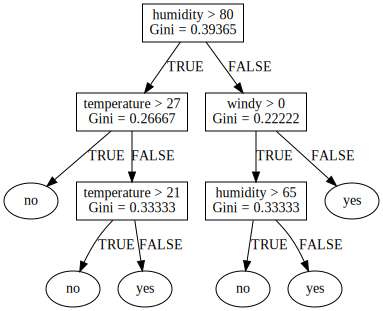

In [ ]:
# C'est juste une visualisation du graphe
# Si ça ne marche pas, ce n'ai pas grave
try:
    from IPython.display import SVG
    from graphviz import Source
    from IPython.display import display

    graph = Source(cart_classifier.graphviz())
    display(SVG(graph.pipe(format='svg')))

except ImportError:
    print('You have to install graphviz: https://graphviz.org/download/')

## II. Application and Analysis

In this section, we will test different concepts by running an experiment, formulating a hypothesis and trying to justify it.
We will use [Cars Data](https://www.kaggle.com/abineshkumark/carsdata) just for 3 classes: US., Euroupe. and Japan.

In [ ]:
# Dataset import
cars_data = pd.read_csv('data/cars.csv', skipinitialspace=True)
# Remove missing values
cars_data.dropna(inplace=True)
# Yay! We did it! These are the first samples
cars_data.head()

,mpg,cylinders,cubicinches,hp,weightlbs,time-to-60,year,brand
0,14.0,8,350.0,165,4209.0,12,1972,US.
1,31.9,4,89.0,71,1925.0,14,1980,Europe.
2,17.0,8,302.0,140,3449.0,11,1971,US.
3,15.0,8,400.0,150,3761.0,10,1971,US.
4,30.5,4,98.0,63,2051.0,17,1978,US.


In [ ]:
cars_data.dtypes

mpg            float64
cylinders        int64
cubicinches    float64
hp               int64
weightlbs      float64
time-to-60       int64
year             int64
brand           object
dtype: object

In [ ]:
X_cars = cars_data.values[:, :-1]
Y_cars = cars_data.values[:,  -1]

X_cars_train, X_cars_test, Y_cars_train, Y_cars_test = train_test_split(X_cars,
                                                                        Y_cars,
                                                                        test_size=0.2,
                                                                        random_state=0)

X_cars_train.shape, X_cars_test.shape

((204, 7), (52, 7))

### II.1. Decision trees and Random forests

We want to test the effect of different hyper-parameters of decision trees.


In Scikit-learn's implemtation (**DecisionTreeClassifier**), features are always randomly permuted at each split.
The tree will be undeterministic (which is good for overfitting, but not good for tessting the effect of hyper-parameters).
In this case, we stop this property using **random_state=0**.

#### II.1.1. Feature selection criteria

In scikit-learn, there is only CART which can use both:
1. Entropy
1. Gini

Both will generate slightly different decision tree structures. We want to test the effect of the structure on training and test.

In [ ]:
Xtrain = X_cars_train
Ytrain = Y_cars_train
Xtest  = X_cars_test
Ytest  = Y_cars_test
fnames = cars_data.columns


gini_stats         = []
entropy_stats      = []
gini_classifier    = DecisionTreeClassifier(criterion='gini'   , random_state=0, min_samples_leaf=7)
entropy_classifier = DecisionTreeClassifier(criterion='entropy', random_state=0, min_samples_leaf=7)

# ============ GINI ====================
# ................ Train ..............
temps_debut = timeit.default_timer()
gini_classifier.fit(Xtrain, Ytrain)
gini_stats.append(timeit.default_timer() - temps_debut)
# ........... Evaluation train .........
gini_stats.append(f1_score(Ytrain, gini_classifier.predict(Xtrain), average='micro'))
# ................ Test ................
temps_debut = timeit.default_timer()
Ychoix_pred = gini_classifier.predict(Xtest)
gini_stats.append(timeit.default_timer() - temps_debut)
# ........... Evaluation test ...........
gini_stats.append(f1_score(Ytest, Ychoix_pred, average='micro'))

# =========== Entropy ==================
# ............ Train ............
temps_debut = timeit.default_timer()
entropy_classifier.fit(Xtrain, Ytrain)
entropy_stats.append(timeit.default_timer() - temps_debut)
# ........... Evaluation train ........
entropy_stats.append(f1_score(Ytrain, entropy_classifier.predict(Xtrain), average='micro'))
# ................ Test ................
temps_debut = timeit.default_timer()
Ychoix_pred = entropy_classifier.predict(Xtest)
entropy_stats.append(timeit.default_timer() - temps_debut)
# ........... Evaluation test ...........
entropy_stats.append(f1_score(Ytest, Ychoix_pred, average='micro'))

print('Fin')

Fin


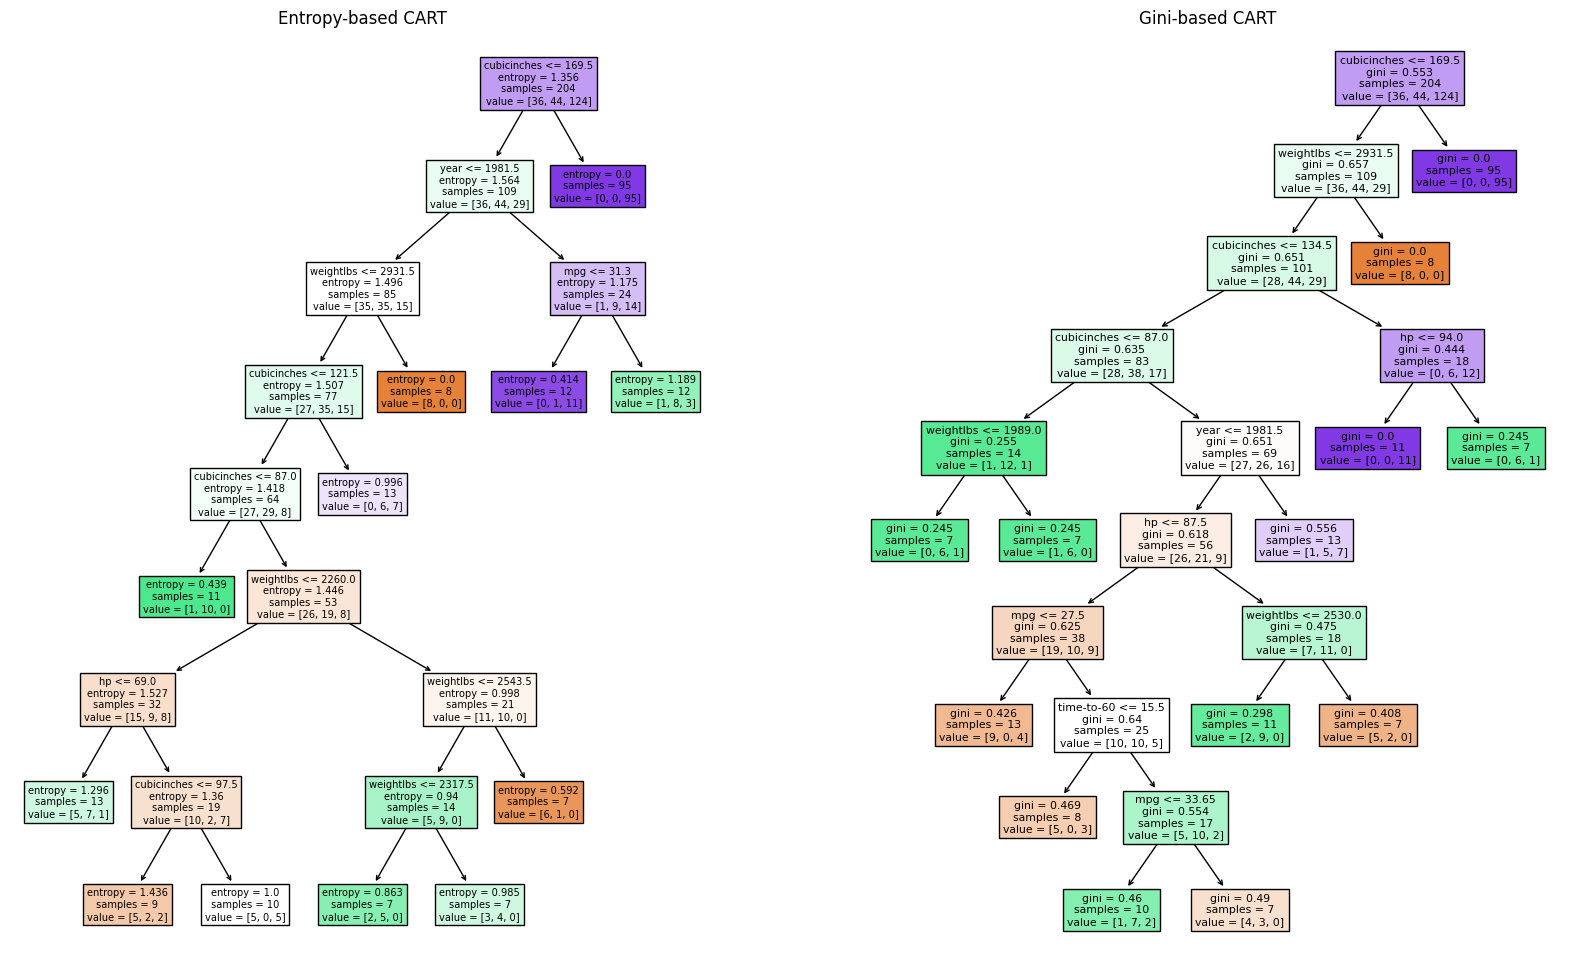

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_figwidth (20)
fig.set_figheight(12)
tree.plot_tree(entropy_classifier, ax=ax1, feature_names=fnames, filled=True)
tree.plot_tree(gini_classifier   , ax=ax2, feature_names=fnames, filled=True)
ax1.set_title('Entropy-based CART')
ax2.set_title('Gini-based CART')
plt.show()

In [ ]:
pd.DataFrame({
    'Criteria' : ['Train Time', 'Train F1', 'Test Time', 'Test F1'],
    'Entropy-based CART' : entropy_stats,
    'Gini-based CART'    : gini_stats
})

,Criteria,Entropy-based CART,Gini-based CART
0,Train Time,0.001664,0.005158
1,Train F1,0.838235,0.872549
2,Test Time,0.000270,0.000362
3,Test F1,0.788462,0.807692


**TODO: Analyze the results**

1. Compare the two trees' structures (depth, leafs number, position of leafs)
1. Justify the training time based on the algorithms and trees structures
1. Justify the test time based on the algorithms and trees structures

**Answers**

1. Comparing both decision trees, we note that while the initial/first split is the same in both trees, the Gini-based CART tree (10 levels) is deeper than the entropy-based CART tree (9 levels). Additionally, the Gini-based tree has more leaves (13 leaves for Gini and 12 for entropy). However, the depth of the leaves (the distance from the root node to the leaf nodes) is approximately the same in both trees.
1. As can be seen, the training time when using the Entropy criterion is much higher than Gini. This can be justified by the fact that Gini impurity is less expensive to calculate than entropy, which is more complex due to its use of logarithms.
1. We notice the same trend in the testing dataset, where the entropy-based CART takes more time than the Gini-based one. We can attribute this to the same reason mentioned earlier. The difference in time is more noticeable here, possibly because differences of the larger/different datasets.


#### II.1.2. Maximum depth

We want to test the effect of stopping creteria "maximum depth", so we used F1 score as classification quality measure.

For each maximum depth, we trained a decision/random forest tree and calculated its F1 score on training data (to test convergence) and on test data (to test generalization).

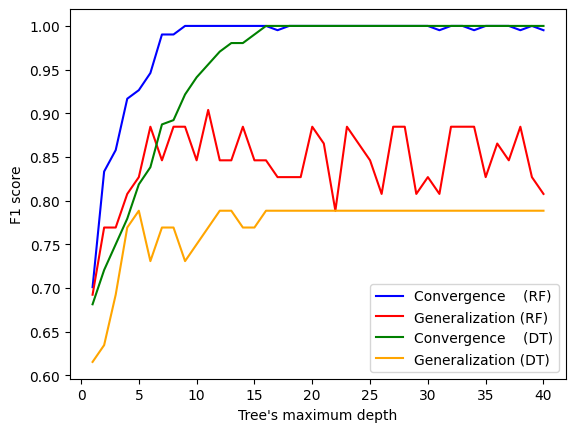

In [ ]:
MAX_DEPTH     = 40
MAX_DEPTH_lst = range(1, MAX_DEPTH+1, 1)

f1_trn_md_DT  = []
f1_tst_md_DT  = []
f1_trn_md_RF  = []
f1_tst_md_RF  = []
for max_depth in MAX_DEPTH_lst:
    mdl_DT = DecisionTreeClassifier(random_state=0, max_depth=max_depth)
    mdl_DT.fit(X_cars_train, Y_cars_train)
    f1_trn_md_DT.append(f1_score(Y_cars_train, mdl_DT.predict(X_cars_train), average='micro'))
    f1_tst_md_DT.append(f1_score(Y_cars_test , mdl_DT.predict(X_cars_test) , average='micro'))

    mdl_RF = RandomForestClassifier(n_estimators=30, max_depth=max_depth)
    mdl_RF.fit(X_cars_train, Y_cars_train)
    f1_trn_md_RF.append(f1_score(Y_cars_train, mdl_RF.predict(X_cars_train), average='micro'))
    f1_tst_md_RF.append (f1_score(Y_cars_test , mdl_RF.predict(X_cars_test) , average='micro'))


plt.plot(MAX_DEPTH_lst, f1_trn_md_RF, color='blue'  , label='Convergence    (RF)')
plt.plot(MAX_DEPTH_lst, f1_tst_md_RF, color='red'   , label='Generalization (RF)')
plt.plot(MAX_DEPTH_lst, f1_trn_md_DT, color='green' , label='Convergence    (DT)')
plt.plot(MAX_DEPTH_lst, f1_tst_md_DT, color='orange', label='Generalization (DT)')
plt.ylabel('F1 score')
plt.xlabel('Tree\'s maximum depth')
plt.legend()
#plt.rcParams["figure.figsize"] = (3,7)
plt.show()

**TODO: Analyze the results**

1. Why F1 score (convergence) is not enhanced after depth=17 in decision trees (DT)?
1. Why F1 score (convergence) is not enhanced after depth=17 in random Forest?
//this question seems to be wrong, so we will suppose that it is  about Generalization (DT)
1. Why Random forests (RF) converge better then decision trees (DT) with less maximum depth?
1. Why Random forests (RF) generalize better then decision trees (DT)?

**Answers**

1. As can be seen, the F1 score (convergence) is not enhanced after a depth of 17 in decision trees (DT). We can explain this by considering the possibility of irrelevant features. Splitting based on these features may not enhance the impurity criterion, or it may be that the impurity criterion is already optimized. After a depth of 17, all the leaves of the tree are homogeneous classes, which means that further splitting and increasing the depth will not be helpful. Furthermore, this behavior may also indicate overfitting, as the model tends to memorize the training dataset after a certain depth.
1. For generalization (DT), we can see that initially, the increase in depth helps the model capture more complex patterns, which results in improved performance on the test dataset (highest F1 score at depth 5). However, as depth continues to increase, the generalization capacity of the model declines, leading to fluctuations in performance on the test dataset. In the end, the model stabilizes at its previously reached highest F1 score, which suggests that increasing depth does not necessarily lead to improved performance.
1. Random forests (RF) converge better than decision trees (DT) with less maximum depth (7 instead of 17) because RF benefits from the averaging effect of multiple trees in the forest. Each tree in the forest is trained on a random subset of the training data, leading to a reduction in overfitting compared to a single decision tree.
1. Random forests (FA) generalize better than decision trees (AD) because they take advantage of the diversity of trees in the forest to improve generalization. The random sampling of learning instances for each tree and the random subset of features considered for each division help decorrelate individual trees and reduce overfitting. In addition, FR aggregates predictions from multiple trees via voting or averaging, which tends to result in more reliable predictions on new data.

#### II.1.3. Minimum leaf samples

We want to test the effect of stopping creteria "mimimum samples in leafs", so we used F1 score as classification quality measure.

For each minimum leaf samples number, we trained a decision tree/random forest and calculated its F1 score on training data (to test convergence) and on test data (to test generalization).

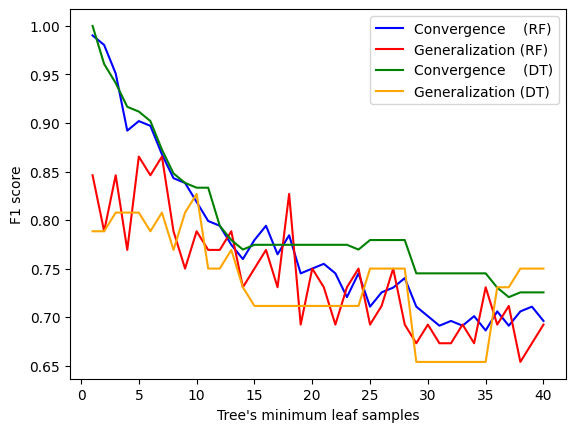

In [ ]:
MIN_LEAF    = 40
MIN_LEAF_lst = range(1, MIN_LEAF+1, 1)

f1_trn_ml_DT = []
f1_tst_ml_DT = []
f1_trn_ml_RF = []
f1_tst_ml_RF = []
for min_samples_leaf in MIN_LEAF_lst:
    mdl_DT = DecisionTreeClassifier(random_state=0, min_samples_leaf=min_samples_leaf)
    mdl_DT.fit(X_cars_train, Y_cars_train)
    f1_trn_ml_DT.append(f1_score(Y_cars_train, mdl_DT.predict(X_cars_train), average='micro'))
    f1_tst_ml_DT.append(f1_score(Y_cars_test , mdl_DT.predict(X_cars_test) , average='micro'))

    mdl_RF = RandomForestClassifier(n_estimators=30, min_samples_leaf=min_samples_leaf)
    mdl_RF.fit(X_cars_train, Y_cars_train)
    f1_trn_ml_RF.append(f1_score(Y_cars_train, mdl_RF.predict(X_cars_train), average='micro'))
    f1_tst_ml_RF.append(f1_score(Y_cars_test , mdl_RF.predict(X_cars_test) , average='micro'))


plt.plot(MIN_LEAF_lst, f1_trn_ml_RF, color='blue'  , label='Convergence    (RF)')
plt.plot(MIN_LEAF_lst, f1_tst_ml_RF, color='red'   , label='Generalization (RF)')
plt.plot(MIN_LEAF_lst, f1_trn_ml_DT, color='green' , label='Convergence    (DT)')
plt.plot(MIN_LEAF_lst, f1_tst_ml_DT, color='orange', label='Generalization (DT)')
plt.ylabel('F1 score')
plt.xlabel('Tree\'s minimum leaf samples')
plt.legend()
#plt.rcParams["figure.figsize"] = (3,7)
plt.show()

**TODO: Analyze the results**
1. Why F1 score of decision trees (DT) gets worst when increasing the minimum leaf samples?
1. Why F1 score of decision trees (DT) gets better then random forests when increasing the minimum leaf samples?

**Answers**

1. By allowing a large number of elements in a leaf node, the model may become less discriminative, which causes : **underfitting**. As a result in we get decrease in F1

2. However, increasing the minimum leaf samples in decision trees (DT) helps prevent overfitting by restricting the complexity of each individual tree. This regularization leads to improved generalization performance and a higher F1 score compared to random forests, especially when the training data is limited.


### II.2. Ensemle Learning

Random forests are just bagging over decision trees.
We want to test different hyper-parameters of ensemble learning.

#### II.2.1. Estimators' number

We want to test the effect of estimators' number in both AdaBoost and Bagging.
We applied these two ensemble learning techniques on decision trees and logistic regression.

In [ ]:
MAX_ESTIMATORS     = 50
MAX_ESTIMATORS_lst = range(1, MAX_ESTIMATORS+1, 1)

mdls = [
    ('Logistic Regression', LogisticRegression(solver='liblinear')),
    ('Decision Tree', DecisionTreeClassifier(random_state=0))
]

mdls_perf = {}
for mdl_name, mdl in mdls:
    mdls_perf[mdl_name] = {'bagging': [], 'boosting': []}

for n_estimators in MAX_ESTIMATORS_lst:
    for mdl_name, mdl in mdls:
        mdl_bagging  = BaggingClassifier (estimator=mdl, n_estimators=n_estimators)
        mdl_boosting = AdaBoostClassifier(estimator=mdl, n_estimators=n_estimators, algorithm='SAMME')

        mdl_bagging.fit(X_cars_train, Y_cars_train)
        Y_pred = mdl_bagging.predict(X_cars_test)
        mdls_perf[mdl_name]['bagging'].append(accuracy_score(Y_cars_test, Y_pred))


        mdl_boosting.fit(X_cars_train, Y_cars_train)
        Y_pred = mdl_boosting.predict(X_cars_test)
        mdls_perf[mdl_name]['boosting'].append(accuracy_score(Y_cars_test, Y_pred))

print('DONE')

DONE


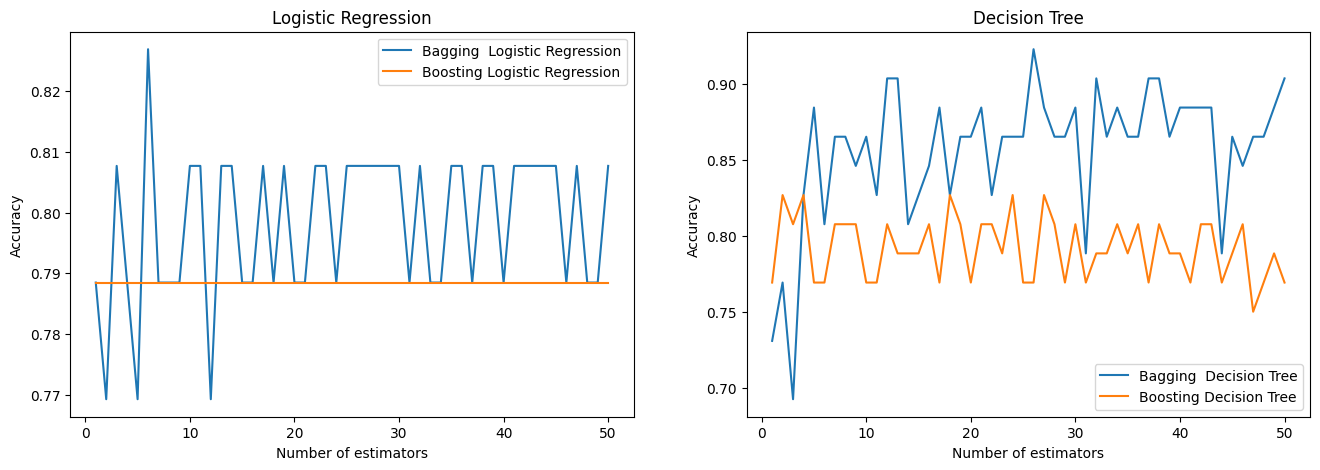

In [ ]:
fig, axs = plt.subplots(1, len(mdls), figsize=(16,5))

for i, (mdl_name, mdl) in enumerate(mdls):
    axs[i].plot(MAX_ESTIMATORS_lst, mdls_perf[mdl_name]['bagging' ], label='Bagging  ' + mdl_name)
    axs[i].plot(MAX_ESTIMATORS_lst, mdls_perf[mdl_name]['boosting'], label='Boosting ' + mdl_name)

    axs[i].set_ylabel('Accuracy')
    axs[i].set_xlabel('Number of estimators')
    axs[i].set_title(mdl_name)
    axs[i].legend()


# plt.ylabel('Accuracy')
# plt.xlabel('Number of estimators')
# plt.legend()
#plt.rcParams["figure.figsize"] = (3,7)
plt.show()

**TODO: Analyze the results**
1. Why Bagging is better than boosting in this experiment (according to the data)?
1. Propose a logical hypothesis to why Logistic Regression does not improve using boosting.
1. Why bagging is enhancing accuracy using decision trees?
1. Why boosting is not enhancing accuracy as much as bagging using decision trees?

**Answers**

1. Bagging tries to solve over-fitting problem while Boosting tries to reduce bias.

2. because logistic regression is a linear model, it draws straight lines to separate data, while boosting works best with models that can capture non-linear patterns. When you add two linear models together, the result is another linear model which isn't good match for AdaBoost that works by combining weak learners to form a strong learner.

3. Decision trees have a tendency to overfit the training data, bagging reduces that by by training multiple models on different subsets of the data hence it gives us better accuracy .

4. Because of it's sequential learning process.  As the number of estimators increases, boosting tend to become more prone to overfitting . It also prioritize reducing bias at the expense of increasing variance  unlike baggin where it aims for balance

#### II.2.2. Bootstrap's size

In this expreiment, we are interested in bagging; more precisely, Bootstrap's size.

*P.S. We used SGD instead of linear logistic regression because this latter has some problems with bagging*

In [ ]:
BAG_PERC_lst = np.arange(0.1, 1, 0.01)

mdls_bag = [
    ('Logistic Regression', SGDClassifier()),
    # ('Logistic Regression', LogisticRegression(solver='liblinear')),
    ('Decision Tree', DecisionTreeClassifier(random_state=0))
]

mdls_bag_perf = {}
for mdl_name, mdl in mdls_bag:
    mdls_bag_perf[mdl_name] = {'train': [], 'test': []}

for max_samples in BAG_PERC_lst:
    for mdl_name, mdl in mdls_bag:
        mdl_bagging  = BaggingClassifier (estimator=mdl, n_estimators=20, max_samples=max_samples)

        mdl_bagging.fit(X_cars_train, Y_cars_train)
        Y_pred = mdl_bagging.predict(X_cars_train)
        mdls_bag_perf[mdl_name]['train'].append(accuracy_score(Y_cars_train, Y_pred))

        Y_pred = mdl_bagging.predict(X_cars_test)
        mdls_bag_perf[mdl_name]['test'].append(accuracy_score(Y_cars_test, Y_pred))

print('DONE')

DONE


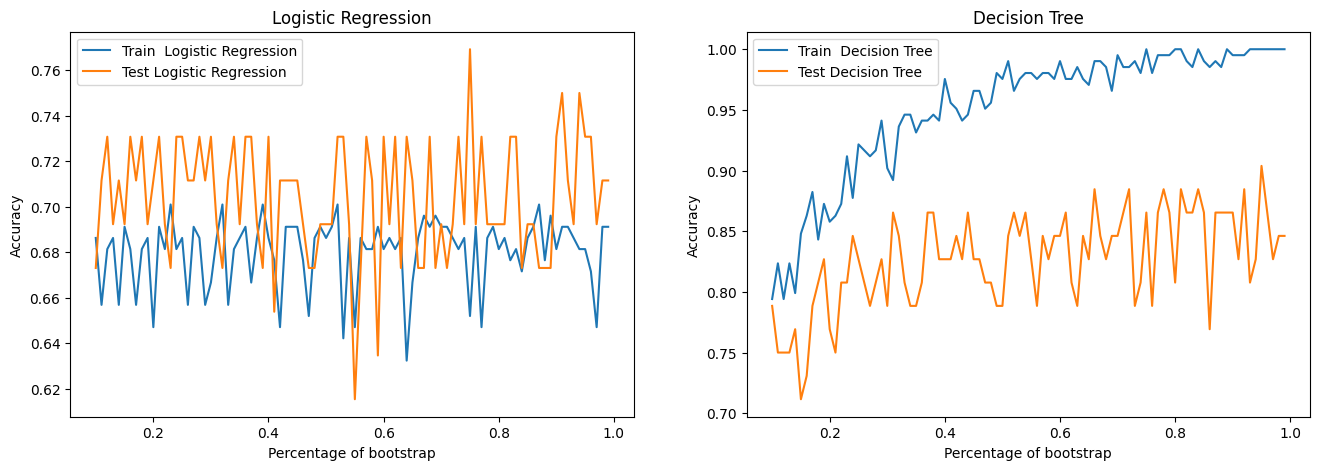

In [ ]:
fig, axs = plt.subplots(1, len(mdls_bag), figsize=(16,5))

for i, (mdl_name, mdl) in enumerate(mdls_bag):
    axs[i].plot(BAG_PERC_lst, mdls_bag_perf[mdl_name]['train' ], label='Train  ' + mdl_name)
    axs[i].plot(BAG_PERC_lst, mdls_bag_perf[mdl_name]['test']  , label='Test '   + mdl_name)

    axs[i].set_ylabel('Accuracy')
    axs[i].set_xlabel('Percentage of bootstrap')
    axs[i].set_title(mdl_name)
    axs[i].legend()


# plt.ylabel('Accuracy')
# plt.xlabel('Number of estimators')
# plt.legend()
#plt.rcParams["figure.figsize"] = (3,7)
plt.show()

**TODO: Analyze the results**
1. Why the accuracy's cruve is not smooth?
1. Why increasing the size of a bootstrap increases the accuracy in case of decision trees?
1. Why it does not in case of logistic regression?

**Answers**

1. due to randomness in the selection of bootstrap samples for training  qui introduces variability into the training process,

2. When we increase the size of the bootstrap it means we are diversing our training data which results in better generalization .

3. due to the linear nature of logistic regression therefore the benefits of increasing the size of the bootstrap sample done't apply on it.

In [ ]:
print('Trees and forests are crucial for life on earth')
print('Not these trees though :)')
print("Well, that's a relief! Imagine if these were real trees; I would be habe utterly disappointed because these ones aren't exactly pleasant.")


Trees and forests are crucial for life on earth
Not these trees though :)
Well, that's a relief! Imagine if these were real trees; I would be habe utterly disappointed because these ones aren't exactly pleasant.
